## 矩阵分解

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
data = np.loadtxt('movielens_100k.csv', delimiter=',', dtype=int)
print('数据集大小：', len(data))

数据集大小： 100000


In [4]:
# 用户和电影都是从编号1开始，转换为从0开始
data[:, :2] = data[:, :2]-1

In [5]:
# 计算用户和电影的数量
users = set()
items = set()
for i, j, k in data:
    users.add(i)
    items.add(j)
user_num = len(users)
item_num = len(items)

print(f'用户数量:{user_num},电影数量:{item_num}')

用户数量:943,电影数量:1682


In [7]:
# 设置随机种子，划分训练集与测试集
np.random.seed(0)

ratio = 0.8
split = int(len(data) * ratio)
np.random.shuffle(data)
train = data[:split]
test = data[split:]

In [8]:
# 统计训练集中每个用户和电影出现的数量，作为正则化的权重
user_cnt = np.bincount(train[:, 0], minlength=user_num)
item_cnt = np.bincount(train[:, 1], minlength=item_num)
print(user_cnt[:10])
print(item_cnt[:10])

[215  47  42  19 139 170 320  47  18 156]
[371 109  70 172  70  21 308 158 240  68]


In [9]:
# 用户和电影的编号要作为下标，必须保存为整数
user_train, user_test = train[:, 0], test[:, 0]
item_train, item_test = train[:, 1], test[:, 1]
y_train, y_test = train[:, 2], test[:, 2]

In [11]:
class MF:
    def __init__(self, N, M, d) -> None:
        # N是用户数量，M是电影数量，d是特征维度
        # 定义模型参数
        self.user_params = np.ones((N, d))
        self.item_params = np.ones((M, d))

    def pred(self, user_id, item_id):
        # 预测用户对电影的打分
        # 获得用户偏好的电影特征
        user_param = self.user_params[user_id]
        item_param = self.item_params[item_id]
        # 返回预测的评分
        rating_pred = np.sum(user_param*item_param, axis=1)
        return rating_pred

    def update(self, user_grad, item_grad, lr):
        # 根据参数的梯度更新参数
        self.user_params -= lr*user_grad
        self.item_params -= lr*item_grad

In [12]:
def train(model, learning_rate, lbd, max_training_step, batch_size):
    train_losses = []
    test_losses = []
    batch_num = int(np.ceil(len(user_train) / batch_size))
    with tqdm(range(max_training_step * batch_num)) as pbar:
        for epoch in range(max_training_step):
            # 随机梯度下降
            train_rmse = 0
            for i in range(batch_num):
                # 获取当前批量
                st = i * batch_size
                ed = min(len(user_train), st + batch_size)
                user_batch = user_train[st: ed]
                item_batch = item_train[st: ed]
                y_batch = y_train[st: ed]
                # 计算模型预测
                y_pred = model.pred(user_batch, item_batch)
                # 计算梯度
                P = model.user_params
                Q = model.item_params
                errs = y_batch - y_pred
                P_grad = np.zeros_like(P)
                Q_grad = np.zeros_like(Q)
                for user, item, err in zip(user_batch, item_batch, errs):
                    P_grad[user] = P_grad[user] - err * Q[item] + lbd * P[user]
                    Q_grad[item] = Q_grad[item] - err * P[user] + lbd * Q[item]
                model.update(P_grad / len(user_batch), Q_grad /
                             len(user_batch), learning_rate)

                train_rmse += np.mean(errs ** 2)
                # 更新进度条
                pbar.set_postfix({
                    'Epoch': epoch,
                    'Train RMSE': f'{np.sqrt(train_rmse / (i + 1)):.4f}',
                    'Test RMSE': f'{test_losses[-1]:.4f}' if test_losses else None
                })
                pbar.update(1)

            # 计算测试集上的RMSE
            train_rmse = np.sqrt(train_rmse / len(user_train))
            train_losses.append(train_rmse)
            y_test_pred = model.pred(user_test, item_test)
            test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
            test_losses.append(test_rmse)

    return train_losses, test_losses

100%|██████████| 37500/37500 [00:41<00:00, 911.19it/s, Epoch=29, Train RMSE=0.9673, Test RMSE=1.0048] 


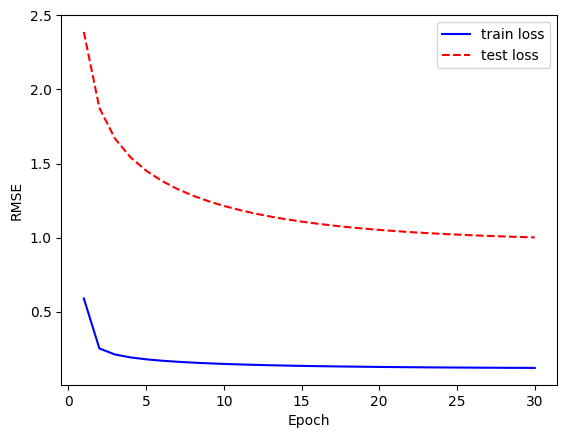

In [13]:
# 超参数
feature_num = 16  # 特征数
learning_rate = 0.1  # 学习率
lbd = 1e-4  # 正则化强度
max_training_step = 30
batch_size = 64  # 批量大小

# 建立模型
model = MF(user_num, item_num, feature_num)
# 训练部分
train_losses, test_losses = train(model, learning_rate, lbd,
                                  max_training_step, batch_size)

plt.figure()
x = np.arange(max_training_step) + 1
plt.plot(x, train_losses, color='blue', label='train loss')
plt.plot(x, test_losses, color='red', ls='--', label='test loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [14]:
y_test_pred = model.pred(user_test, item_test)
print(y_test_pred[:10])  # 把张量转换为numpy数组
print(y_test[:10])

[2.57712395 3.48622005 3.76150216 3.58604004 4.8058418  3.47284112
 3.37246031 4.0917956  3.02605747 3.45742155]
[2 4 4 4 5 2 3 1 4 4]


## 因子分解机

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics  # sklearn中的评价指标函数库
from tqdm import tqdm

# 导入数据集
data = np.loadtxt('fm_dataset.csv', delimiter=',')

# 划分数据集
np.random.seed(0)
ratio = 0.8
split = int(ratio * len(data))
x_train = data[:split, :-1]
y_train = data[:split, -1]
x_test = data[split:, :-1]
y_test = data[split:, -1]
# 特征数
feature_num = x_train.shape[1]
print('训练集大小：', len(x_train))
print('测试集大小：', len(x_test))
print('特征数：', feature_num)

训练集大小： 800
测试集大小： 200
特征数： 24


In [16]:
class FM:

    def __init__(self, feature_num, vector_dim):
        # vector_dim代表公式中的k，为向量v的维度
        self.theta0 = 0.0  # 常数项
        self.theta = np.zeros(feature_num)  # 线性参数
        self.v = np.random.normal(size=(feature_num, vector_dim))  # 双线性参数
        self.eps = 1e-6  # 精度参数

    def _logistic(self, x):
        # 工具函数，用于将预测转化为概率
        return 1 / (1 + np.exp(-x))

    def pred(self, x):
        # 线性部分
        linear_term = self.theta0 + x @ self.theta
        # 双线性部分
        square_of_sum = np.square(x @ self.v)
        sum_of_square = np.square(x) @ np.square(self.v)
        # 最终预测
        y_pred = self._logistic(linear_term
                                + 0.5 * np.sum(square_of_sum - sum_of_square, axis=1))
        # 为了防止后续梯度过大，对预测值进行裁剪，将其限制在某一范围内
        y_pred = np.clip(y_pred, self.eps, 1 - self.eps)
        return y_pred

    def update(self, grad0, grad_theta, grad_v, lr):
        self.theta0 -= lr * grad0
        self.theta -= lr * grad_theta
        self.v -= lr * grad_v

In [17]:
# 超参数设置，包括学习率、训练轮数等
vector_dim = 16
learning_rate = 0.01
lbd = 0.05
max_training_step = 200
batch_size = 32

# 初始化模型
np.random.seed(0)
model = FM(feature_num, vector_dim)

train_acc = []
test_acc = []
train_auc = []
test_auc = []

with tqdm(range(max_training_step)) as pbar:
    for epoch in pbar:
        st = 0
        while st < len(x_train):
            ed = min(st + batch_size, len(x_train))
            X = x_train[st: ed]
            Y = y_train[st: ed]
            st += batch_size
            # 计算模型预测
            y_pred = model.pred(X)
            # 计算交叉熵损失
            cross_entropy = -Y * np.log(y_pred) \
                - (1 - Y) * np.log(1 - y_pred)
            loss = np.sum(cross_entropy)
            # 计算损失函数对y的梯度，再根据链式法则得到总梯度
            grad_y = (y_pred - Y).reshape(-1, 1)
            # 计算y对参数的梯度
            # 常数项
            grad0 = np.sum(grad_y * (1 / len(X) + lbd))
            # 线性项
            grad_theta = np.sum(grad_y * (X / len(X)
                                          + lbd * model.theta), axis=0)
            # 双线性项
            grad_v = np.zeros((feature_num, vector_dim))
            for i, x in enumerate(X):
                # 先计算sum(x_i * v_i)
                xv = x @ model.v
                grad_vi = np.zeros((feature_num, vector_dim))
                for s in range(feature_num):
                    grad_vi[s] += x[s] * xv - (x[s] ** 2) * model.v[s]
                grad_v += grad_y[i] * grad_vi
            grad_v = grad_v / len(X) + lbd * model.v
            model.update(grad0, grad_theta, grad_v, learning_rate)

            pbar.set_postfix({
                '训练轮数': epoch,
                '训练损失': f'{loss:.4f}',
                '训练集准确率': train_acc[-1] if train_acc else None,
                '测试集准确率': test_acc[-1] if test_acc else None
            })
        # 计算模型预测的准确率和AUC
        # 预测准确率，阈值设置为0.5
        y_train_pred = (model.pred(x_train) >= 0.5)
        acc = np.mean(y_train_pred == y_train)
        train_acc.append(acc)
        auc = metrics.roc_auc_score(y_train, y_train_pred)  # sklearn中的AUC函数
        train_auc.append(auc)

        y_test_pred = (model.pred(x_test) >= 0.5)
        acc = np.mean(y_test_pred == y_test)
        test_acc.append(acc)
        auc = metrics.roc_auc_score(y_test, y_test_pred)
        test_auc.append(auc)

print(f'测试集准确率：{test_acc[-1]}，\t测试集AUC：{test_auc[-1]}')

100%|██████████| 200/200 [00:48<00:00,  4.09it/s, 训练轮数=199, 训练损失=11.3006, 训练集准确率=0.816, 测试集准确率=0.785]


测试集准确率：0.79，	测试集AUC：0.7201320910484726


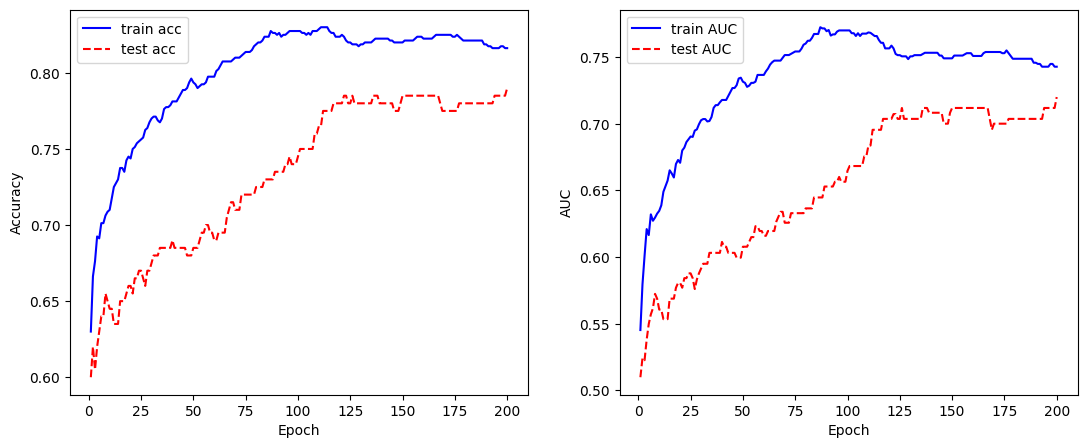

In [18]:
# 绘制训练曲线
plt.figure(figsize=(13, 5))
x_plot = np.arange(len(train_acc)) + 1

plt.subplot(121)
plt.plot(x_plot, train_acc, color='blue', label='train acc')
plt.plot(x_plot, test_acc, color='red', ls='--', label='test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(x_plot, train_auc, color='blue', label='train AUC')
plt.plot(x_plot, test_auc, color='red', ls='--', label='test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()